In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
#Load dataset
print("MOVIE GENRE CLASSIFICATION PROJECT-NAIVE BAYES")
df = pd.read_csv('movie_dataset.csv')
df.head()

MOVIE GENRE CLASSIFICATION PROJECT-NAIVE BAYES


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,12/15/2021,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,3/1/2022,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2/25/2022,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,11/24/2021,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,12/22/2021,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [5]:
#Cleaning dataset
df = df.dropna(subset=['Genre', 'Popularity', 'Vote_Count', 'Vote_Average', 'Original_Language', 'Release_Date', 'Overview'])
df.head(5)

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,12/15/2021,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,3/1/2022,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2/25/2022,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,11/24/2021,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,12/22/2021,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [6]:
#Convert the string value to numeric
df['Popularity'] = pd.to_numeric(df['Popularity'], errors='coerce')
df['Vote_Count'] = pd.to_numeric(df['Vote_Count'], errors='coerce')
df['Vote_Average'] = pd.to_numeric(df['Vote_Average'], errors='coerce')

In [7]:
# Drop rows where conversion failed (NaN)
df = df.dropna(subset=['Popularity', 'Vote_Count', 'Vote_Average'])

In [8]:
#Assigning independent variable and target variable and finding out the number of unique genres
df['Main_Genre']=df['Genre'].str.split(',').str[0].str.strip()
# Using distinct genres (Animation, Horror, Documentary)
distinct_genres = ['Animation', 'Horror', 'Documentary']
df = df[df['Main_Genre'].isin(distinct_genres)]

In [9]:
print(f"Using genres: {distinct_genres}")
print(f"Total movies: {len(df)}")
print(df['Main_Genre'].value_counts())

Using genres: ['Animation', 'Horror', 'Documentary']
Total movies: 1856
Main_Genre
Horror         868
Animation      804
Documentary    184
Name: count, dtype: int64


In [10]:
# Numerical features
le = LabelEncoder()
df['Language_Encoded'] = le.fit_transform(df['Original_Language'])
df['Release_Year'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year
df = df.dropna(subset=['Release_Year'])
df['Vote_Score'] = df['Vote_Count'] * df['Vote_Average']
df['Popularity_Per_Vote'] = df['Popularity'] / (df['Vote_Count'] + 1)

In [11]:
X_numeric = df[['Popularity', 'Vote_Count', 'Vote_Average', 'Language_Encoded', 'Release_Year', 'Vote_Score', 'Popularity_Per_Vote']]
y = df['Main_Genre']

In [12]:
# Text features from Overview
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['Overview'].fillna(''))

In [13]:
# Combine
from scipy.sparse import hstack
X_combined = hstack([X_numeric.values, X_text])

In [14]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining: {X_train.shape[0]}, Testing: {X_test.shape[0]}")


Training: 1484, Testing: 372


In [15]:
# Naive bayes
# Scaling to positive values for MultinomialNB
scaler_nb = MinMaxScaler()
X_train_scaled = scaler_nb.fit_transform(X_train.toarray())
X_test_scaled = scaler_nb.transform(X_test.toarray())

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_scaled, y_train)
pred = nb.predict(X_test_scaled)
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, average='weighted', zero_division=0)
rec = recall_score(y_test, pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred, average='weighted', zero_division=0)

In [16]:
print(f"\nNaive Bayes:")
print(f"  Accuracy:  {acc*100:.2f}%")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")


Naive Bayes:
  Accuracy:  71.24%
  Precision: 0.7276
  Recall:    0.7124
  F1-Score:  0.7058


In [17]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

   Animation       0.66      0.80      0.72       161
 Documentary       0.87      0.35      0.50        37
      Horror       0.76      0.71      0.73       174

    accuracy                           0.71       372
   macro avg       0.76      0.62      0.65       372
weighted avg       0.73      0.71      0.71       372

[[129   1  31]
 [ 16  13   8]
 [ 50   1 123]]


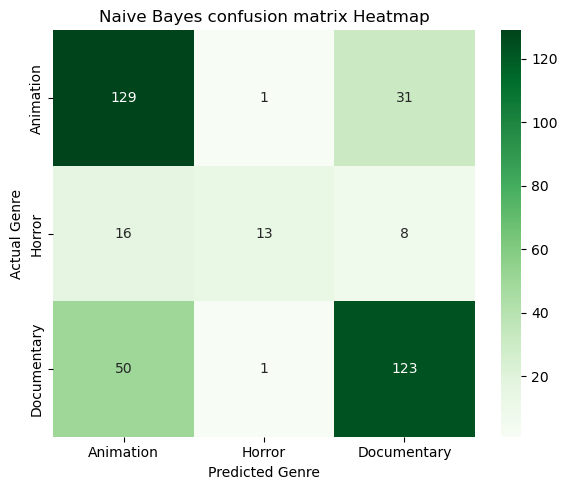

In [36]:
# Creating confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Animation', 'Horror', 'Documentary'],
    yticklabels=['Animation', 'Horror', 'Documentary']
)

plt.xlabel('Predicted Genre')
plt.ylabel('Actual Genre')
plt.title('Naive Bayes confusion matrix Heatmap')
plt.tight_layout()
plt.show()
